# Credit Lead Prediction

## Importing the libraries


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
# For Encoding
from sklearn.preprocessing import LabelEncoder

# For Scaling
from sklearn.preprocessing import MinMaxScaler

In [5]:
# For Feature Importance
from sklearn.datasets import make_classification
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
  

In [6]:
# For Cross Validation
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import roc_auc_score

In [7]:
# For Machine Learning Models
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

## Importing the datasets

In [8]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

## Data Exploration

In [9]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 245725 entries, 0 to 245724
Data columns (total 11 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   ID                   245725 non-null  object
 1   Gender               245725 non-null  object
 2   Age                  245725 non-null  int64 
 3   Region_Code          245725 non-null  object
 4   Occupation           245725 non-null  object
 5   Channel_Code         245725 non-null  object
 6   Vintage              245725 non-null  int64 
 7   Credit_Product       216400 non-null  object
 8   Avg_Account_Balance  245725 non-null  int64 
 9   Is_Active            245725 non-null  object
 10  Is_Lead              245725 non-null  int64 
dtypes: int64(4), object(7)
memory usage: 20.6+ MB


In [10]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105312 entries, 0 to 105311
Data columns (total 10 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   ID                   105312 non-null  object
 1   Gender               105312 non-null  object
 2   Age                  105312 non-null  int64 
 3   Region_Code          105312 non-null  object
 4   Occupation           105312 non-null  object
 5   Channel_Code         105312 non-null  object
 6   Vintage              105312 non-null  int64 
 7   Credit_Product       92790 non-null   object
 8   Avg_Account_Balance  105312 non-null  int64 
 9   Is_Active            105312 non-null  object
dtypes: int64(3), object(7)
memory usage: 8.0+ MB


All the columns in both train and test dataset are of the right dtype. Column 'Credit_Product' contains missing values in both the datasets. 

In [11]:
train.describe()

,Age,Vintage,Avg_Account_Balance,Is_Lead
count,245725.000000,245725.000000,2.457250e+05,245725.000000
mean,43.856307,46.959141,1.128403e+06,0.237208
std,14.828672,32.353136,8.529364e+05,0.425372
min,23.000000,7.000000,2.079000e+04,0.000000
25%,30.000000,20.000000,6.043100e+05,0.000000
50%,43.000000,32.000000,8.946010e+05,0.000000
75%,54.000000,73.000000,1.366666e+06,0.000000
max,85.000000,135.000000,1.035201e+07,1.000000


In [12]:
test.describe()

,Age,Vintage,Avg_Account_Balance
count,105312.000000,105312.000000,1.053120e+05
mean,43.871002,46.842819,1.134195e+06
std,14.872890,32.273634,8.662430e+05
min,24.000000,7.000000,2.259700e+04
25%,30.000000,20.000000,6.039822e+05
50%,43.000000,32.000000,8.966345e+05
75%,54.000000,73.000000,1.371598e+06
max,85.000000,135.000000,9.908858e+06


The values in the variables 'Age', 'Vintage' are well within the normal range. The maximum value for 'Avg_Account_Balance' seems to be quite high. This could be due to millionaires having high account balance with seven figures. 

In [13]:
max(train['Avg_Account_Balance'])

10352009

## Data Visualization

In [14]:
categorical = ['Gender','Region_Code','Occupation','Channel_Code','Credit_Product','Is_Active']
train_numerical = train[['Age','Avg_Account_Balance','Vintage']]
test_numerical = test[['Age','Avg_Account_Balance','Vintage']]

### 1. Bar Charts for Categorical Variables 

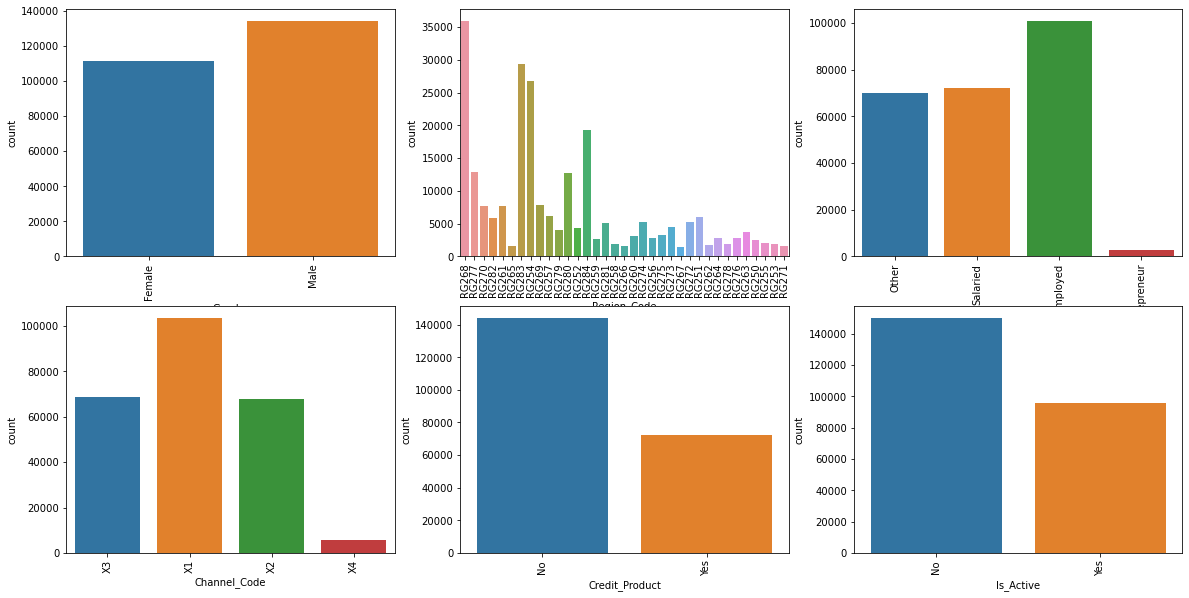

In [15]:

fig, ax = plt.subplots(2, 3, figsize=(20, 10))
for variable, subplot in zip(categorical, ax.flatten()):
    sns.countplot(train[variable], ax=subplot)
    for label in subplot.get_xticklabels():
        label.set_rotation(90)


### 2. Histograms for Numerical Variables

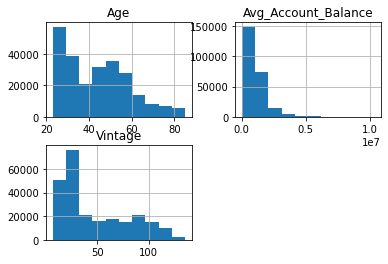

In [16]:
train_numerical.hist()
plt.show()

### 3. Box Plots To Check For Outliers

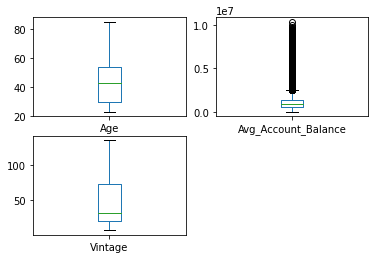

In [17]:
train_numerical.plot(kind='box', subplots=True, layout=(2,2), sharex=False, sharey=False)
plt.show()

While 'Age' and 'Vintage' don't show any outliers, it is observed that 'Avg_Acc_Balance' has huge number of outliers. However, these are not outliers. The variable is strongly skewed towards positive values and contains very high numerical values.

#### The classes of target variable are imbalanced. 

### 4. Plot To Check The Target Variable

<AxesSubplot:xlabel='Is_Lead', ylabel='count'>

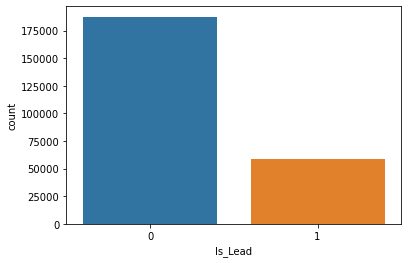

In [18]:
sns.countplot(train['Is_Lead'])

 The classes of target variable are imbalanced. 

In [19]:
train.isnull().sum()

ID                         0
Gender                     0
Age                        0
Region_Code                0
Occupation                 0
Channel_Code               0
Vintage                    0
Credit_Product         29325
Avg_Account_Balance        0
Is_Active                  0
Is_Lead                    0
dtype: int64

'Credit_Product' column in train dataset contains 29325 missing values.

In [20]:
test.isnull().sum()

ID                         0
Gender                     0
Age                        0
Region_Code                0
Occupation                 0
Channel_Code               0
Vintage                    0
Credit_Product         12522
Avg_Account_Balance        0
Is_Active                  0
dtype: int64

'Credit_Product' column in train dataset contains 12522 missing values.

### Checking for duplicate rows


In [21]:
# Checking for duplicate rows
train[train.duplicated(keep = 'last')]


,ID,Gender,Age,Region_Code,Occupation,Channel_Code,Vintage,Credit_Product,Avg_Account_Balance,Is_Active,Is_Lead


In [22]:
test[test.duplicated(keep = 'last')]

,ID,Gender,Age,Region_Code,Occupation,Channel_Code,Vintage,Credit_Product,Avg_Account_Balance,Is_Active


No duplicated rows in both the train and test datasets

## Data Preprocessing

### Removing 'ID' variable

In [23]:
train.drop(['ID'], inplace = True, axis = 1)
test.drop(['ID'], inplace = True, axis = 1)

## Processing Numerical Variables


Numerical variables 'Age' and 'Vintage' have a large range of values. The values can be binned and the variables can be converted to categorical variables

In [24]:
# Creating bins for 'Age' variable
train['Age']=pd.cut(x = train['Age'],
                        bins = [20,40,60,90], 
                        labels = [0, 1, 2])
test['Age']=pd.cut(x = test['Age'],
                        bins = [20,40,60,90], 
                        labels = [0, 1, 2])

In [25]:
# Creating bins for 'Vintage' vintage
train['Vintage']=pd.cut(x = train['Vintage'],
                        bins = [0,36,72,144], 
                        labels = [0, 1, 2])
test['Vintage']=pd.cut(x = test['Vintage'],
                        bins = [0,36,72,144], 
                        labels = [0, 1, 2])

In [26]:
for col in ['Age','Vintage']:    
    train[col] = train[col].astype(np.int32)
    test[col] = test[col].astype(np.int32)

'Avg_Account_Balance' deserves some special attention as it appears to be highly skewed. 

<AxesSubplot:xlabel='Avg_Account_Balance', ylabel='Density'>

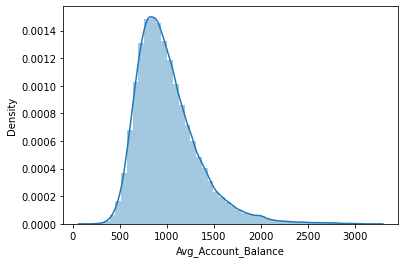

In [27]:
# Square Root Transformation
sqrt_avgaccb = train['Avg_Account_Balance']**(.5)
sns.distplot(sqrt_avgaccb)

<AxesSubplot:xlabel='Avg_Account_Balance', ylabel='Density'>

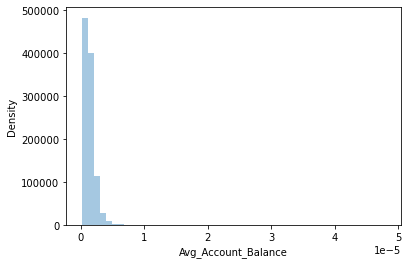

In [28]:
# Reciprocal Transformation
recip_avgaccb = 1/train['Avg_Account_Balance']
sns.distplot(recip_avgaccb)

<AxesSubplot:xlabel='Avg_Account_Balance', ylabel='Density'>

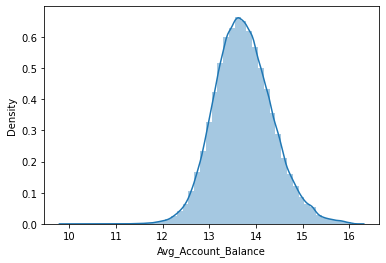

In [29]:
# Log Tranformation
log_avgaccb = np.log(train['Avg_Account_Balance'])
sns.distplot(log_avgaccb)

Out of three tranformations above, it is the log transformation that is most effective, transforming the variable into one with a neat Gaussian distribution.

In [30]:
# Transforming the variable 'Avg_Account_Balance' with Log
train['Avg_Account_Balance'] = np.log(train['Avg_Account_Balance'])
test['Avg_Account_Balance'] = np.log(test['Avg_Account_Balance'])

## Encoding categorical variables

In [31]:
# Checking the number of labels in each categorical variable
for col in ['Gender','Region_Code','Occupation','Channel_Code','Credit_Product','Is_Active']:
    print(col,"; ",len(train[col].unique()),'labels')

Gender ;  2 labels
Region_Code ;  35 labels
Occupation ;  4 labels
Channel_Code ;  4 labels
Credit_Product ;  3 labels
Is_Active ;  2 labels


In [32]:
for col in ['Gender','Region_Code','Occupation','Channel_Code','Credit_Product','Is_Active']:
    print(col,"; ",len(test[col].unique()),'labels')

Gender ;  2 labels
Region_Code ;  35 labels
Occupation ;  4 labels
Channel_Code ;  4 labels
Credit_Product ;  3 labels
Is_Active ;  2 labels


The labels in the categorical variables are consistent in both the train and test dataset. 

The categorical variables are encoded using LabelEncoder. One-hot encoding is avoided as it is not suitable for tree-based models. It creates absence of levels which decreases the efficiency of these models. Thus, reduces the model accuracy considerably.

In [33]:
# Initiating the packages for encoding
encoder = LabelEncoder()

# Creating a list of categorical columns to iterate over
cat_cols = ['Gender','Region_Code','Occupation','Channel_Code','Credit_Product','Is_Active']

for col in cat_cols: 
    le = LabelEncoder()
    train[col] = le.fit_transform(train[col])
    test[col] = le.fit_transform(test[col])

In [34]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 245725 entries, 0 to 245724
Data columns (total 10 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   Gender               245725 non-null  int32  
 1   Age                  245725 non-null  int32  
 2   Region_Code          245725 non-null  int32  
 3   Occupation           245725 non-null  int32  
 4   Channel_Code         245725 non-null  int32  
 5   Vintage              245725 non-null  int32  
 6   Credit_Product       245725 non-null  int32  
 7   Avg_Account_Balance  245725 non-null  float64
 8   Is_Active            245725 non-null  int32  
 9   Is_Lead              245725 non-null  int64  
dtypes: float64(1), int32(8), int64(1)
memory usage: 11.2 MB


In [35]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105312 entries, 0 to 105311
Data columns (total 9 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   Gender               105312 non-null  int32  
 1   Age                  105312 non-null  int32  
 2   Region_Code          105312 non-null  int32  
 3   Occupation           105312 non-null  int32  
 4   Channel_Code         105312 non-null  int32  
 5   Vintage              105312 non-null  int32  
 6   Credit_Product       105312 non-null  int32  
 7   Avg_Account_Balance  105312 non-null  float64
 8   Is_Active            105312 non-null  int32  
dtypes: float64(1), int32(8)
memory usage: 4.0 MB


## Missing Value Imputation

The best method for missing value imputation in this case is to impute the most frequent values as K-NN imputation cannot be used as the test dataset doesn't have the target variable. It is incomplete and therefore K-NN cannot predict missing values for independent variables in the test dataset. 

In [36]:
train = train.apply(lambda x:x.fillna(x.value_counts().index[0]))
test = test.apply(lambda x:x.fillna(x.value_counts().index[0]))

In [37]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 245725 entries, 0 to 245724
Data columns (total 10 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   Gender               245725 non-null  int32  
 1   Age                  245725 non-null  int32  
 2   Region_Code          245725 non-null  int32  
 3   Occupation           245725 non-null  int32  
 4   Channel_Code         245725 non-null  int32  
 5   Vintage              245725 non-null  int32  
 6   Credit_Product       245725 non-null  int32  
 7   Avg_Account_Balance  245725 non-null  float64
 8   Is_Active            245725 non-null  int32  
 9   Is_Lead              245725 non-null  int64  
dtypes: float64(1), int32(8), int64(1)
memory usage: 11.2 MB


## Scaling

In [38]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
train[['Age','Region_Code','Occupation','Channel_Code','Vintage','Avg_Account_Balance','Gender','Credit_Product','Is_Active']] = sc.fit_transform(train[['Age','Region_Code','Occupation','Channel_Code','Vintage','Avg_Account_Balance','Gender','Credit_Product','Is_Active']])
test = sc.transform(test)

In [39]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 245725 entries, 0 to 245724
Data columns (total 10 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   Gender               245725 non-null  float64
 1   Age                  245725 non-null  float64
 2   Region_Code          245725 non-null  float64
 3   Occupation           245725 non-null  float64
 4   Channel_Code         245725 non-null  float64
 5   Vintage              245725 non-null  float64
 6   Credit_Product       245725 non-null  float64
 7   Avg_Account_Balance  245725 non-null  float64
 8   Is_Active            245725 non-null  float64
 9   Is_Lead              245725 non-null  int64  
dtypes: float64(9), int64(1)
memory usage: 18.7 MB


In [40]:
#test = pd.DataFrame(test)

## Splitting the Train dataset into X and y

In [41]:
X= train.drop(columns = ['Is_Lead'], axis=1)
y= train['Is_Lead']

## Feature Selection

### 1. Correlation Heat Map

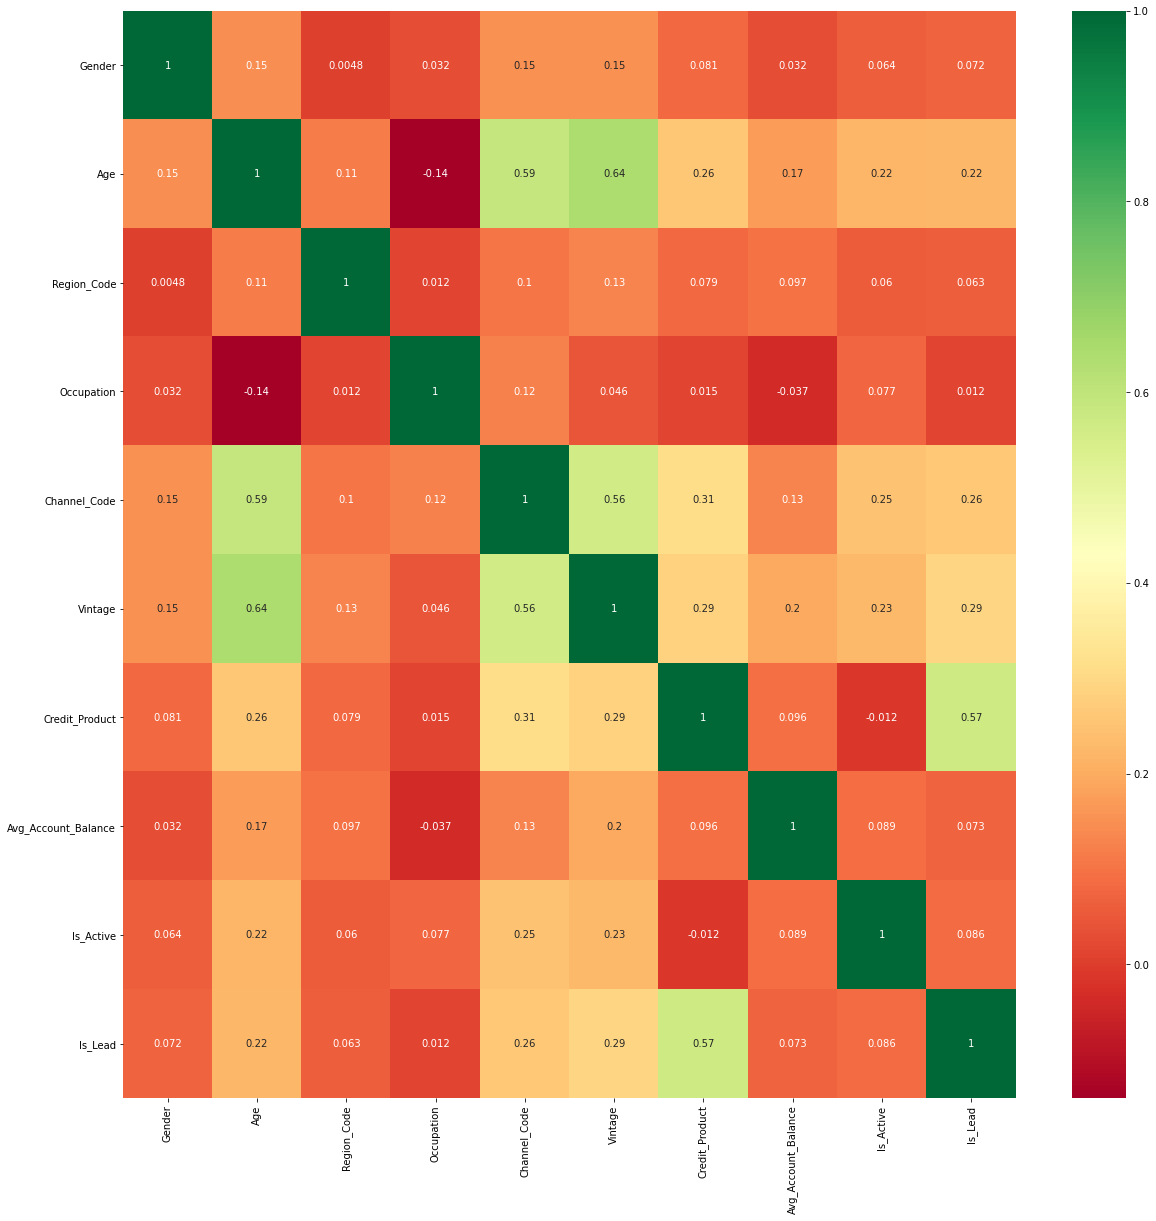

In [42]:
# Getting the correlations of each features in dataset
corrmat = train.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(20,20))

# Plotting the heat map
g=sns.heatmap(train[top_corr_features].corr(),annot=True,cmap="RdYlGn")

### 2. Feature Selection with Anova Fscore

ANOVA with F-score can be used for feature selection with numerical and categorical input for a classification problem.

In [43]:
# Defining feature selection 
fs = SelectKBest(score_func=f_classif,k='all')

# Applying feature selection
fs_fit = fs.fit(X,y)
dfscores = pd.DataFrame(fs_fit.scores_)
dfcolumns = pd.DataFrame(X.columns)

# Concatenating two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns
print(featureScores)


print(fs.get_support())

                 Specs          Score
0               Gender    1282.895877
1                  Age   12891.271956
2          Region_Code     963.664144
3           Occupation      37.880216
4         Channel_Code   17993.767753
5              Vintage   23014.793926
6       Credit_Product  118533.617237
7  Avg_Account_Balance    1327.046407
8            Is_Active    1819.062919
[ True  True  True  True  True  True  True  True  True]


## Building the Machine Learning Models and Stratified K-Fold Cross Validation

Our train dataset contains imbalanced proportions of labels in the target variable. Therefore, it is advisable to use to stratified k-fold cross validation during model building and evaluation to ensure both classes of target variable are equally represented.

In [44]:
# Implementing cross validation
def skfold_cv(X, y, algorithm, params,n_jobs=-1):
    skf = StratifiedKFold(n_splits=10, random_state=1, shuffle = True)
 
 
    for train_index , test_index in skf.split(X,y):
        X_train , X_test = X.iloc[train_index,:],X.iloc[test_index,:]
        y_train , y_test = y[train_index] , y[test_index]

        model = algorithm(**params) 
        model.fit(X_train,y_train)
        pred = model.predict_proba(X_test)[:,1]

        score = roc_auc_score(y_test, pred)
        print(f"score: {score}")
        
    return model
   

Our dataset has large number of observations compared to the number of features. Hence, we should low bias/high variance algorithms like K-NN, tree-based algorithms.

### 1. Logistic Regression

In [45]:
lg_params = {}
lg_model = skfold_cv(X, y,LogisticRegression,lg_params)



score: 0.8495657959777986
score: 0.853836780122816
score: 0.8499857485132363
score: 0.8557464894170149
score: 0.8497711250215727
score: 0.8542958775405705
score: 0.8501418600829411
score: 0.8588853259949134
score: 0.8569640597429375
score: 0.8536670045156768


### 2. K-NN Classifier

In [46]:
knn_params = {'n_neighbors': 5, 'metric': 'minkowski', 'p': 2}
knn_model = skfold_cv(X, y,KNeighborsClassifier,knn_params)


score: 0.8122930189150206
score: 0.8180773277196515
score: 0.8173517429849296
score: 0.8179282458738143
score: 0.8124539625082383
score: 0.8178678032609876
score: 0.8144191133155289
score: 0.8270193938109514
score: 0.8232162515488026
score: 0.8132692795920645


### 3. Random Forest Classifier

In [47]:
rf_params = {'criterion': 'entropy', 'random_state': 0}
rf_model = skfold_cv(X, y,RandomForestClassifier,rf_params)

score: 0.8198963257651724
score: 0.8229934682775506
score: 0.8237362095288345
score: 0.8205618878615297
score: 0.81832921595241
score: 0.8234335696642784
score: 0.817589539885891
score: 0.830670846801048
score: 0.8280248403734135
score: 0.8189385225462157


### 4. XGBoost Classifier

In [48]:
xgb_params = {'learning_rate': 0.05,'verbosity': 0}
xgb_model = skfold_cv(X, y,XGBClassifier,xgb_params) 

score: 0.8665830788732248
score: 0.8714442902051182
score: 0.8687164315294911
score: 0.8707346355408558
score: 0.8664834804665942
score: 0.8691104466172255
score: 0.8658294516061658
score: 0.8770773432775226
score: 0.8744894222395666
score: 0.8696691403665294


### 5. CatBoost Classifier

In [49]:
catb_params = {'n_estimators':100, 'learning_rate': 0.05,'verbose':0}
catb_model = skfold_cv(X, y, CatBoostClassifier, catb_params)

score: 0.8666088845805852
score: 0.8708947004861193
score: 0.8682815557077082
score: 0.8709230689166791
score: 0.8654749893958176
score: 0.8692665111998502
score: 0.8651615645810137
score: 0.8761284031999613
score: 0.8740643353080444
score: 0.868751686853811


### 6. LightGBM Classifier

In [50]:
lgbm_params = {'n_estimators':100, 'learning_rate': 0.05,'verbose':0}
lgbm_model = skfold_cv(X, y, LGBMClassifier, lgbm_params)

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004005 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
score: 0.8672107401239786
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003393 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
score: 0.8716595086146672
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003840 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
score: 0.8687408231628002
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003632 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
score:

## Predicting test results
Since, the ensemble models are all effective with AUC score of ~86%. The predictions from the three models are calculated.

In [51]:
pred_xgb = xgb_model.predict_proba(test)[:,1]
pred_catb = catb_model.predict_proba(test)[:,1]
pred_lgbm = lgbm_model.predict_proba(test)[:,1]

The average of these predictions are taken as the final predicted values. 

In [52]:
pred_avg = (pred_xgb + pred_catb + pred_lgbm)/3